In [2]:
# Khai báo các thư viện cần thiết
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, StringType, StructType, StructField, TimestampType
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, mean

In [3]:
# Khởi tạo SparkSession
spark = SparkSession.builder.master("local").appName("ReadFileExample").getOrCreate()

def read_data(file_path):
    try:
        df = spark.read.csv(file_path, header=True, inferSchema=True)
        print(f"Dữ liệu đã được đọc thành công từ {file_path}")
        df = df.toDF(*[
    c.lower()
     .strip()
     .replace(" ", "_")
     .replace(".", "")
     .replace("|", "")
     for c in df.columns
])
        return df
    except Exception as e:
        print(f"Đã xảy ra lỗi khi đọc dữ liệu: {e}")
        return None

# Định nghĩa đường dẫn tới file CSV
file_path = "Data/air_quality_data_vietnam_with_noise.csv"  
df = read_data(file_path)
if df:
    df.show()  

Dữ liệu đã được đọc thành công từ Data/air_quality_data_vietnam_with_noise.csv
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|            date|   location|       pm25|       pm10|         co|        no2|        so2|         o3|temperature|   humidity|   rainfall| wind_speed|air_quality|
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|30/10/2021 22:00|    Cần Thơ|99.15644454|35.21473435|1.271065018|18.70978842|9.629661325|0.102995706| 34.8184835|       NULL|60.77593531|3.465304919|        Kém|
|05/02/2021 20:00|    Cần Thơ|20.89457956|93.59945821|0.620299207|1.966236989|3.014902023|0.196140536|26.22189021|       NULL|       NULL|23.26059058|        Tốt|
|13/08/2021 14:00|     Hà Nội|118.5472225|       NULL|1.548638071|     9999.0|6.175145303|0.111960451|26.3

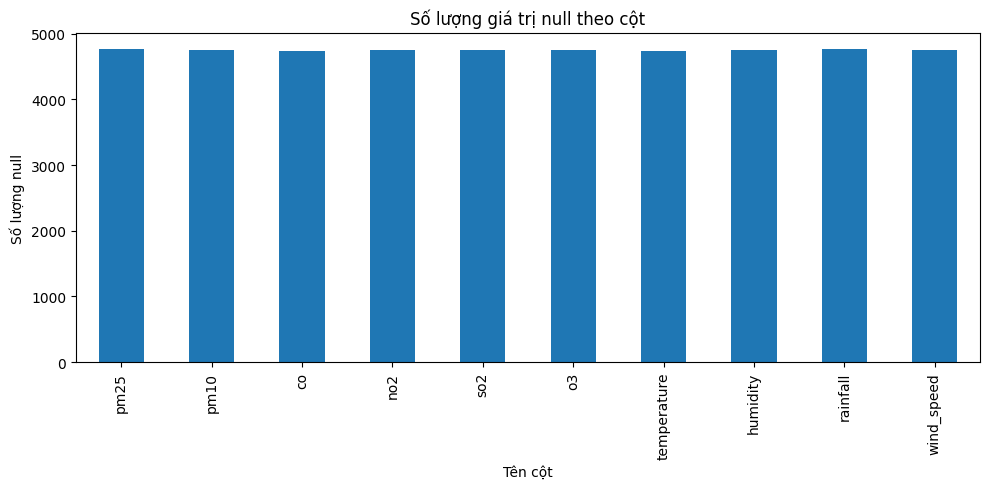

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()

# Tính số lượng giá trị null trên mỗi cột
null_counts = pandas_df.isnull().sum()
null_counts = null_counts[null_counts > 0]  

# Vẽ biểu đồ
null_counts.plot(kind='bar', figsize=(10,5), title='Số lượng giá trị null theo cột')
plt.ylabel('Số lượng null')
plt.xlabel('Tên cột')
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import col, sum, when
from pyspark.sql import Row

# Đếm null cho từng cột, lưu thành list (tên_cột, số_null)
null_counts = []
for c in df.columns:
    null_count = df.select(
        sum(when(col(c).isNull(), 1).otherwise(0)).alias('null_count')
    ).collect()[0]['null_count']
    null_counts.append((c, null_count))

# Chuyển list thành DataFrame với 2 cột: Column, NullCount
null_counts_df = spark.createDataFrame(
    [Row(Column=col_name, NullCount=null_count) for col_name, null_count in null_counts]
)

null_counts_df.show(truncate=False)


+-----------+---------+
|Column     |NullCount|
+-----------+---------+
|date       |0        |
|location   |0        |
|pm25       |4772     |
|pm10       |4753     |
|co         |4731     |
|no2        |4757     |
|so2        |4755     |
|o3         |4753     |
|temperature|4739     |
|humidity   |4752     |
|rainfall   |4760     |
|wind_speed |4748     |
|air_quality|0        |
+-----------+---------+



In [6]:
def summarization_data(df):
    print("==================== Sơ lược dữ liệu ====================")

    # 1. Bảng mô tả thống kê cơ bản
    numeric_cols = [col.name for col in df.schema.fields if isinstance(col.dataType, NumericType)]
    df.select(numeric_cols).describe().show()

    # 2. Phương sai và độ lệch chuẩn
    variance, stddev = {}, {}
    for col in df.columns:
        if isinstance(df.schema[col].dataType, NumericType):
            variance[col] = df.select(F.var_pop(col)).first()[0]
            stddev[col] = df.select(F.stddev_pop(col)).first()[0]
    print("\n==================== Phương sai (Variance) ====================")
    for col, val in variance.items():
        print(f"{col}: {val}")
    print("\n==================== Độ lệch chuẩn (Standard Deviation) ====================")
    for col, val in stddev.items():
        print(f"{col}: {val}")

    # 3. Q1, Q3
    quantiles = {}
    for col in df.columns:
        if isinstance(df.schema[col].dataType, NumericType):
            try:
                q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.0)
                quantiles[col] = {"Q1": q1, "Q3": q3}
            except:
                pass
    print("\n==================== Q1, Q3 ====================")
    for col, q in quantiles.items():
        print(f"{col}: Q1={q['Q1']}, Q3={q['Q3']}")

    # 4. Trung vị (Median)
    median = {}
    for col in df.columns:
        if isinstance(df.schema[col].dataType, NumericType):
            med_list = df.approxQuantile(col, [0.5], 0.0)
            median[col] = med_list[0] if med_list else None
    print("\n==================== Trung vị (Median) ====================")
    for col, val in median.items():
        print(f"{col}: {val}")

    # 5. Mode
    mode = {}
    for col in df.columns:
        top_value = df.filter(F.col(col).isNotNull()).groupBy(col).count().orderBy(F.desc("count")).first()
        mode[col] = top_value[col] if top_value else None
    print("\n==================== Mode (Giá trị xuất hiện nhiều nhất) ====================")
    for col, val in mode.items():
        print(f"{col}: {val}")

    # 6. Tỷ lệ thiếu dữ liệu (%)
    print("\n==================== Missing Data (%) ====================")
    total_count = df.count()
    if total_count == 0:
        print("DataFrame is empty.")
    else:
        missing_pct = df.select([
            ((F.count(F.when(F.col(col).isNull(), col)) / total_count) * 100).alias(col)
            for col in df.columns
        ])
        result = missing_pct.collect()[0].asDict()
        for col, pct in result.items():
            print(f"{col}: {pct:.2f}%")

    # 7. Dòng trùng lặp
    duplicate_count = df.count() - df.distinct().count()
    print(f"\n==================== Duplicated Rows ====================\nSố lượng dòng trùng lặp: {duplicate_count}")

    # 8. Số giá trị khác nhau
    print("\n==================== Distinct Values per Column ====================")
    for col in df.columns:
        distinct_count = df.select(col).distinct().count()
        print(f"{col}: {distinct_count}")

    return df
summarization_data(df)

==================== Sơ lược dữ liệu ====================
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|              pm25|              pm10|                co|               no2|               so2|                o3|       temperature|          humidity|          rainfall|        wind_speed|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             45228|             45247|             45269|             45243|             45245|             45247|             45261|             45248|             45240|             45252|
|   mean|252.57068778196077| 283.4291113996883|191.18428933024995|196.47913219632173|187.32716146584792|182.21068299723188|207.59995760434091|

DataFrame[date: string, location: string, pm25: double, pm10: double, co: double, no2: double, so2: double, o3: double, temperature: double, humidity: double, rainfall: double, wind_speed: double, air_quality: string]

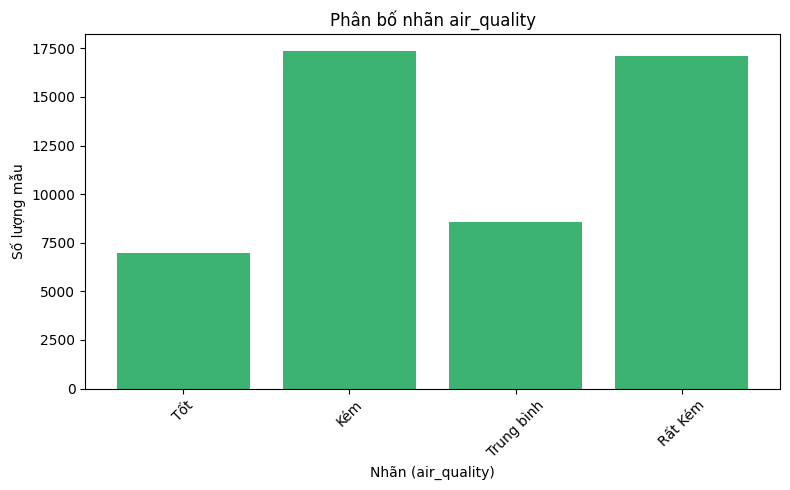

In [7]:
# Chuyển về pandas DataFrame để vẽ
label_counts = df.groupBy("air_quality").count().toPandas()

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 5))
plt.bar(label_counts["air_quality"], label_counts["count"], color='mediumseagreen')
plt.xlabel("Nhãn (air_quality)")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố nhãn air_quality")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print("==================== Loại bỏ data trùng lặp ===============")
df = df.dropDuplicates()
df.show()

==================== Loại bỏ data trùng lặp ===============
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|            date|   location|       pm25|       pm10|         co|        no2|        so2|         o3|temperature|   humidity|   rainfall| wind_speed|air_quality|
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| 10/06/2021 0:00|    Cần Thơ|90.76330436|181.8406282|1.888366991|17.56492776|        1.0| 0.08246466|22.15208866|62.20791192|56.12451415|13.15610518|        Kém|
|19/08/2021 10:00|     Hà Nội|106.7215317|67.32552907|1.016720641| 9.74023516|6.399931976|0.067865007|31.49073955|79.15473116|69.08529781|11.67632769|    Rất Kém|
|27/10/2021 10:00|     Hà Nội| 27.4198079|        1.0|1.885677837|16.88703319|0.147408805|0.054187716|30.44883113| 81.7338074

In [ ]:
def handle_missing_values(df):
    
    numeric_cols = [col.name for col in df.schema.fields if isinstance(col.dataType, NumericType)]
    for column in numeric_cols:
        mean_val = df.select(mean(col(column))).first()[0]
        df = df.fillna({column: mean_val})
    
    return df

df = handle_missing_values(df)
df.show()  


+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|            date|   location|       pm25|       pm10|         co|        no2|        so2|         o3|temperature|   humidity|   rainfall| wind_speed|air_quality|
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| 10/06/2021 0:00|    Cần Thơ|90.76330436|181.8406282|1.888366991|17.56492776|        1.0| 0.08246466|22.15208866|62.20791192|56.12451415|13.15610518|        Kém|
|19/08/2021 10:00|     Hà Nội|106.7215317|67.32552907|1.016720641| 9.74023516|6.399931976|0.067865007|31.49073955|79.15473116|69.08529781|11.67632769|    Rất Kém|
|27/10/2021 10:00|     Hà Nội| 27.4198079|        1.0|1.885677837|16.88703319|0.147408805|0.054187716|30.44883113| 81.7338074|        0.0|40.18753939| Trung bình|
|26/05/2021 16:00|    

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType

def remove_abnormal_values(df):
    for col in df.columns:
        if isinstance(df.schema[col].dataType, NumericType):
            # Lọc bỏ các giá trị âm
            df = df.filter(F.col(col) >= 0)
            
            if col == "pm25":
                df = df.filter(F.col(col) <= 150)  
            elif col == "pm10":
                df = df.filter(F.col(col) <= 500)  
            elif col == "co":
                df = df.filter(F.col(col) <= 10)  
            elif col == "no2":
                df = df.filter(F.col(col) <= 200) 
            elif col == "so2":
                df = df.filter(F.col(col) <= 500)  
            elif col == "o3":
                df = df.filter(F.col(col) <= 200)  
            elif col == "temperature":
                df = df.filter(F.col(col) >= -40) 
                df = df.filter(F.col(col) <= 50)  
            elif col == "humidity":
                df = df.filter(F.col(col) >= 0)  
                df = df.filter(F.col(col) <= 100)  
            elif col == "rainfall":
                df = df.filter(F.col(col) >= 0)  
            elif col == "wind_speed":
                df = df.filter(F.col(col) >= 0)  
    
    return df

df_cleaned = remove_abnormal_values(df)

df_cleaned.show()
print(f"Số lượng dòng sau khi loại bỏ các giá trị bất thường: {df_cleaned.count()}")

# Xuất dữ liệu ra file CSV
output_path = "Data/Output.csv" 
df_cleaned.coalesce(1).write.mode("overwrite").option("header", "true").csv(output_path)




+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
|            date|   location|       pm25|       pm10|         co|        no2|        so2|         o3|temperature|   humidity|   rainfall| wind_speed|air_quality|
+----------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| 10/06/2021 0:00|    Cần Thơ|90.76330436|181.8406282|1.888366991|17.56492776|        1.0| 0.08246466|22.15208866|62.20791192|56.12451415|13.15610518|        Kém|
|19/08/2021 10:00|     Hà Nội|106.7215317|67.32552907|1.016720641| 9.74023516|6.399931976|0.067865007|31.49073955|79.15473116|69.08529781|11.67632769|    Rất Kém|
|27/10/2021 10:00|     Hà Nội| 27.4198079|        1.0|1.885677837|16.88703319|0.147408805|0.054187716|30.44883113| 81.7338074|        0.0|40.18753939| Trung bình|
|26/05/2021 16:00|    